## FBCCA and Extended FBCCA for SSVEP signals classification

In [2]:
# Imports:
from tqdm import tqdm

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as sio

import re

from sklearn.cross_decomposition import CCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

from scipy.signal import butter, lfilter, periodogram

import pandas as pd

import os

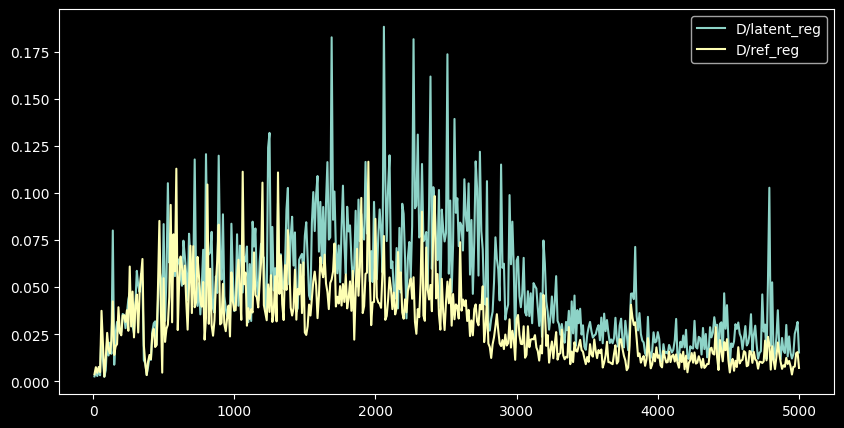

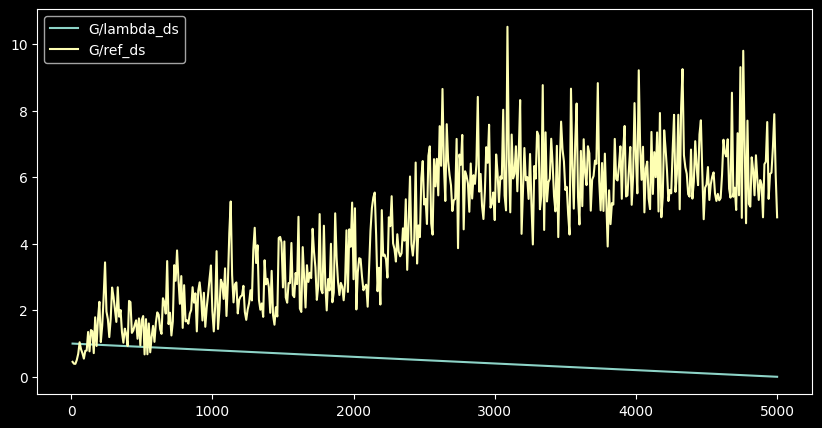

In [ ]:

df = pd.read_csv('expr/checkpoints/SSVEP_w_0.1s_log.txt')
"""
Index(['time', 'iteration', 'D/latent_real', 'D/latent_fake', 'D/latent_reg',
       'D/ref_real', 'D/ref_fake', 'D/ref_reg', 'G/latent_adv', 'G/latent_sty',
       'G/latent_ds', 'G/latent_cyc', 'G/ref_adv', 'G/ref_sty', 'G/ref_ds',
       'G/ref_cyc', 'G/lambda_ds'],
      dtype='object')
"""

# Plots: 
# Disceriminators:
plt.figure(figsize=(10, 5))
plt.plot(df['iteration'], df['D/latent_reg'], label='D/latent_reg')
plt.plot(df['iteration'], df['D/ref_reg'], label='D/ref_reg')
plt.legend()
plt.show()

# Generators:
plt.figure(figsize=(10, 5))
plt.plot(df['iteration'], df['G/lambda_ds'], label='G/lambda_ds')
# plt.plot(df['iteration'], df['D/latent_real'], label='D/latent_real')
plt.plot(df['iteration'], df['G/ref_ds'], label='G/ref_ds')
plt.legend()
plt.show()



In [3]:
# get the src data for the model: 
os.makedirs('data/colorado/processed', exist_ok=True)

subjects = ['s1_trial1.csv', 's2_trial2.csv', 's3_trial3.csv', 's4_trial4.csv']
for i, subject in enumerate(subjects):
	df = pd.read_csv(f'data/colorado/processed/{subject}')

	os.makedirs(f'data/colorado/test/{i}', exist_ok=True)

	segment = df.iloc[:1024].values.swapaxes(0, 1)
	np.save(f'data/colorado/test/{i}/1024_segment.npy', segment)

In [1]:
class Args:
    img_size = 1024
    num_domains = 4
    latent_dim = 16
    hidden_dim = 512
    style_dim = 64
    lambda_reg = 1
    lambda_cyc = 1
    lambda_sty = 1
    lambda_ds = 1
    ds_iter = 5000
    w_hpf = 0  # For SSVEP
    randcrop_prob = 0.5
    total_iters = 5000
    resume_iter = 0
    batch_size = 8
    val_batch_size = 8
    lr = 5e-4
    f_lr = 1e-6
    beta1 = 0.0
    beta2 = 0.99
    weight_decay = 1e-4
    num_outs_per_domain = 2
    mode = 'train'
    num_workers = 16
    seed = 777
    train_img_dir = 'data/train'
    val_img_dir = 'data/val'
    # sample_dir = 'expr/samples'
    checkpoint_dir = 'expr/checkpoints'
    eval_dir = 'expr/eval'
    result_dir = 'expr/results'
    print_every = 10
    sample_every = 250
    save_every = 1000
    eval_every = 2500
    runType = f'w_4s'
    sample_dir = f'expr/samples/{runType}'

args = Args()
args.skip_data = False  # Add this line to initialize skip_data attribute

In [2]:
SRC_DIR = "data/colorado/test/"
REF_DIR = "data/ref/"
NUM_DOMAINS = 4
IMG_SIZE = 1024
VAL_BATCH_SIZE = 4
NUM_WORKERS = 4

import os
from munch import Munch
from core.data_loader import get_test_loader
from core.solver import Solver

def subdirs(dname):
    return [d for d in os.listdir(dname)
            if os.path.isdir(os.path.join(dname, d))]

# assert len(subdirs(SRC_DIR)) == NUM_DOMAINS?
assert len(subdirs(REF_DIR)) == NUM_DOMAINS

solver = Solver(args)

loaders = Munch(src=get_test_loader(root=SRC_DIR,
                                    img_size=IMG_SIZE,
                                    batch_size=VAL_BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS),
                ref=get_test_loader(root=REF_DIR,
                                    img_size=IMG_SIZE,
                                    batch_size=VAL_BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS))
solver.sample(loaders)

Training on cuda
Number of parameters of generator: 12161329
Number of parameters of mapping_network: 4079872
Number of parameters of style_encoder: 7008622
Number of parameters of discriminator: 6879346
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Preparing DataLoader for the generation phase...
Preparing DataLoader for the generation phase...
Loading checkpoint from expr/checkpoints/SSVEP_w_4s_nets.ckpt...


/home/loaspr/stargan-ssvep/core/checkpoint.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  module_dict = torch.load(fname)


Loading checkpoint from expr/checkpoints/SSVEP_w_4s_nets_ema.ckpt...
Loading checkpoint from expr/checkpoints/SSVEP_w_4s_optims.ckpt...
Working on latent-guided image synthesis...
DEBUG Shape of y_trg_list: tensor([0], device='cuda:0')
DEBUG Shape of z_trg_list: torch.Size([2, 1, 16])
Received x_src with shape: torch.Size([1, 3, 1024])
Length: x9x and Shape of x: torch.Size([3, 1024]) | torch.Size([3, 1024])
Received x_src with shape: torch.Size([1, 3, 1024])
Length: x9x and Shape of x: torch.Size([3, 1024]) | torch.Size([3, 1024])
Received x_src with shape: torch.Size([1, 3, 1024])
Length: x9x and Shape of x: torch.Size([3, 1024]) | torch.Size([3, 1024])
Working on expr/results/ref...
Shape of src.x: torch.Size([1, 3, 1024])
Shape of reference image: torch.Size([4, 3, 1024])
Shape of reference label: torch.Size([4]), value: tensor([0, 1, 2, 3], device='cuda:0')
Shape of reference style: torch.Size([4, 64])
Shape of reference style: torch.Size([4, 1, 64])
GEnerating with s_ref torch.Si

In [ ]:
from core.utils2 import generate_ref_signal, combined_cca

# SSVEP target frequencies
frequencies = [8, 10, 12, 14]
# Number of samples
N = 1024
# Sampling frequency
fs = 250
# Number of harmonics
n_harmonics = 3
# Number of sub-bands
n_subbands = 8
# Filter bank design
filter_bank_design = 'M1'
# Reference signals
ref_signals = generate_ref_signal(
    'data/raw/Freq_Phase.mat', frequencies, N, n_harmonics, fs)

# combined_cca

In [74]:
def get_acc_of_subject_ECCA(subject, path, template_path, target, labels, synt_ratio=0.5):

    synth_template = np.zeros((4, 6, 3, 1024))
    # leave 1 window to perform testing (load 6 out of 7 windows to create the template)
    real_template = np.zeros((4, 6, 3, 1024))

    # Get the synthetic data for the subject (results of StarGan)
    for label in labels:
        synth_template[label] = np.load(f"{template_path}ref_0{label}_b.npy")[
            :6, :, :]  # (8, 3, 1024) 8 is batch_size
        # Get the real data for the subject
        for i in range(6):
            real_template[label, i, :, :] = np.load(
                path + f"{label}/S{subject}_{i}.npy")

    # get the average of the concatenated array
    if synt_ratio == 0:
        template = np.mean(real_template, axis=1)
    elif synt_ratio == 1:
        template = np.mean(synth_template, axis=1)
    else:
        template = np.mean(
            np.concatenate((
                real_template[:,:(int((1 - synt_ratio) * synth_template.shape[0]))],
                synth_template[:,:int(synt_ratio) *
                                   synth_template.shape[0]]
            ), axis = 1), axis=1)

    in_signal = np.load(path + f"{target}/S{subject}_6.npy")
    # print(f"Shape of templates: {real_template.shape}, {synth_template.shape}, {template.shape}")
    target_frequency = combined_cca(
        in_signal, template, fs, n_subbands, filter_bank_design, ref_signals, 8)

    acc = accuracy_score([target], [target_frequency])

    return acc

def get_acc_of_subject(subject, path, label, w_size=4):

    # get all .npy files of the subject
    files = os.listdir(path)

    predictions = []

    for file in files:
        if re.match(f"^{subject}_.\.npy$", file) and file.endswith(".npy"):
            in_signal = np.load(path + file)
            target_frequency = fbcca(
                in_signal, fs, n_subbands, filter_bank_design, ref_signals, 8)
            predictions.append(target_frequency)

    targets = np.ones(len(predictions)) * label
    # calculate the accuracy
    acc = accuracy_score(targets, predictions)

    return acc


In [77]:
data = np.load("expr/results/ref_03_w_4s.npy")
data.shape

(5, 2, 3, 1024)

(5, 2, 3, 1024)


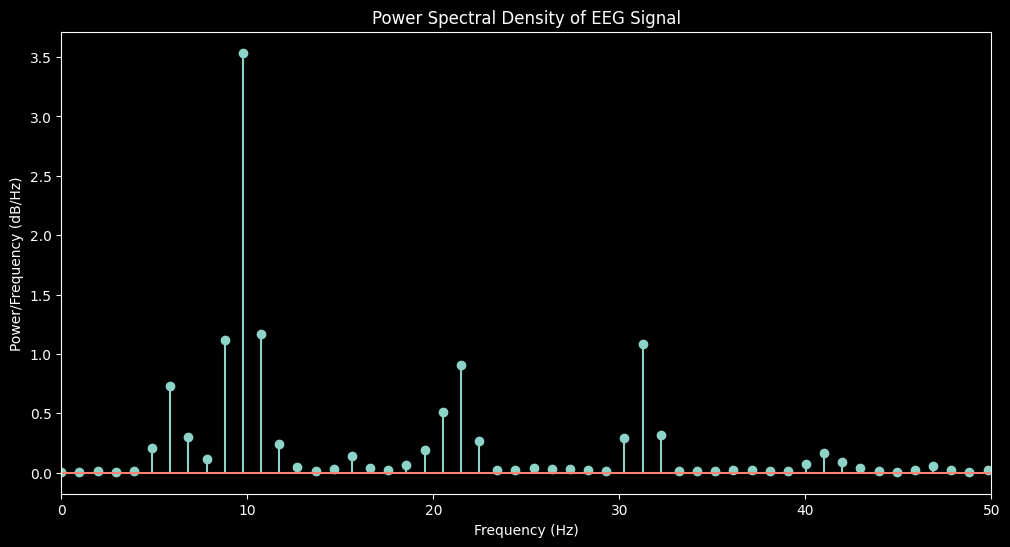

In [87]:
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np


data = np.load("expr/results/ref_03_w_4s.npy")
print(data.shape)

# plot the data
sample = data[4, 1, 2, :] # (3, 1024)
# data[3, 1, 2, :] --> 12 Hz


# plt.figure(figsize=(10, 5))
# plt.plot(data)
# plt.show()

freqs, psd = signal.welch(sample, fs=250)
# set all negatives to 0
plt.figure(figsize=(12, 6))
plt.stem(freqs, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density of EEG Signal')
plt.xlim(0, 50)
plt.show()



# plot the psd of the signal

(9, 3, 1024)


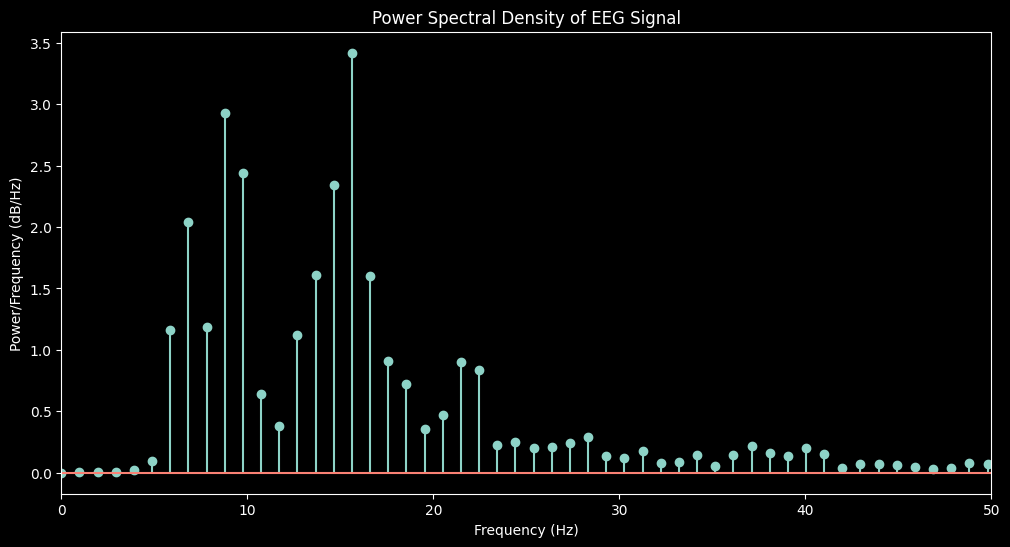

In [ ]:
latent_sig = "expr/samples/w_4s/latent_psi_1.0.jpg_w_4s.npy"

data = np.load(latent_sig)
print(data.shape)

sample = data[2, 2, :]
# data[2, :, :] --> 8hz
# data[3 y 4 y 7, :] --> 10hz
# data[5 y 6, 2, :] --> 12hz
# data[1, 2, :] --> 14hz

In [75]:
template_path = "expr/results/vanilla/"
path = "data/staged/"
labels = [0, 1, 2, 3]

bins = 4
accs_ratio = np.zeros(bins + 1)

for k in range(bins + 1):

    accs = np.zeros(36)

    for label in tqdm(labels):

        path = f"data/staged/"

        for i in range(1, 36):
            acc = get_acc_of_subject_ECCA(
                i, path, template_path, label, labels, synt_ratio=(1/bins) * k)
            accs[i - 1] += acc * 1 / len(labels)

    accs_ratio[k] = np.mean(accs)

print(accs_ratio)

100%|██████████| 4/4 [00:07<00:00,  1.77s/it]

[0.85416667 0.82638889 0.83333333 0.82638889 0.83333333]


In [17]:
labels = [0, 1, 2, 3]

window_size = 4

accs = np.zeros(36)

for label in tqdm(labels):

    path = f"data/staged/{label}/"

    for i in range(1, 36):
        acc = get_acc_of_subject(f"S{i}", path, label, window_size)
        accs[i - 1] += acc * 1 / len(labels)


print(accs)


100%|██████████| 4/4 [00:24<00:00,  6.17s/it]

[1.         0.92857143 1.         0.89285714 0.96428571 1.
 0.92857143 0.92857143 0.92857143 0.92857143 0.67857143 0.89285714
 0.71428571 0.92857143 1.         0.96428571 0.96428571 0.82142857
 0.67857143 0.92857143 0.96428571 0.92857143 0.85714286 1.
 0.92857143 0.92857143 1.         1.         0.78571429 0.92857143
 1.         1.         0.5        0.96428571 0.92857143 0.        ]
